In [28]:
working_dir = '/media/justin/Toshiba HDD/blog_data/02_multiprocessing_tips'

In [32]:
%cd {working_dir}

/media/justin/Toshiba HDD/blog_data/02_multiprocessing_tips


## Find all DAPI images

In [40]:
from glob import glob

paths = glob('images/Week1_22123/Week1_*_w1*.tif')
paths.sort()
len(paths)

240

Show an example

(1024, 1280) uint16 176 10016


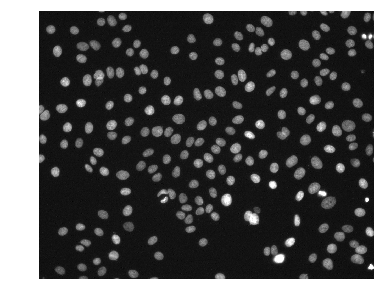

In [71]:
from skimage import io
import matplotlib.pyplot as plt

img = io.imread(paths[0])
print(img.shape, img.dtype, img.min(), img.max())

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray', vmax=4000)
plt.axis('off')
plt.show()

## Using skimage to detect nuclei

(214, 2)


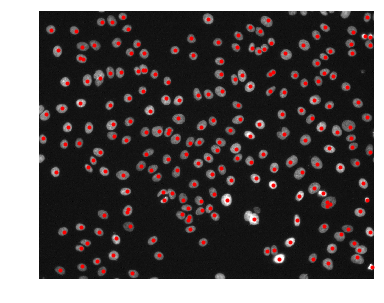

In [78]:
from skimage.filters import gaussian
from skimage.feature import peak_local_max

def detect_nuclei(img, sigma=4, min_distance=6, threshold_abs=1000):
    g = gaussian(img, sigma, preserve_range=True)
    return peak_local_max(g, min_distance, threshold_abs)

centers = detect_nuclei(img)
print(centers.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray', vmax=4000)
plt.plot(centers[:, 1], centers[:, 0], 'r.')
plt.axis('off')
plt.show()

## Method 1 - List comprehension

In [97]:
from tqdm.notebook import tqdm

def process_images1(paths):
    return [detect_nuclei(io.imread(p)) for p in paths]

meth1_times = %timeit -n 4 -r 1 -o centers = process_images1(tqdm(paths))

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


## Method 2 - multiprocessing.Pool

In [101]:
import multiprocessing as mp

def _process_image(path):
    return detect_nuclei(io.imread(path))

def process_images2(paths):
    with mp.Pool() as pool:
        return pool.map(_process_image, paths)

meth2_times = %timeit -n 4 -r 1 -o centers = process_images2(paths)

5.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


## Method 3 - List comprehension from memory

In [104]:
import numpy as np

images = np.asarray([io.imread(p) for p in tqdm(paths)])
images.shape

  0%|          | 0/240 [00:00<?, ?it/s]

(240, 1024, 1280)

In [105]:
def process_images3(images):
    return [detect_nuclei(img) for img in images]

meth3_times = %timeit -n 4 -r 1 -o centers = process_images3(tqdm(images))

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

17.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


## Method 4 - multiprocessing.Pool from memory

In [109]:
def _process_image_memory(img):
    return detect_nuclei(img)

def process_images4(images):
    with mp.Pool() as pool:
        return pool.map(_process_image_memory, images)

meth4_times = %timeit -n 4 -r 1 -o centers = process_images4(images)

5.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


## Method 5 - multiprocessing.Pool with serialization fix

In [110]:
def _process_image_memory_fix(i):
    global images
    return detect_nuclei(images[i])

def process_images5(n):
    with mp.Pool() as pool:
        return pool.map(_process_image_memory_fix, range(n))

meth5_times = %timeit -n 4 -r 1 -o centers = process_images5(len(paths))

5.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


## Results

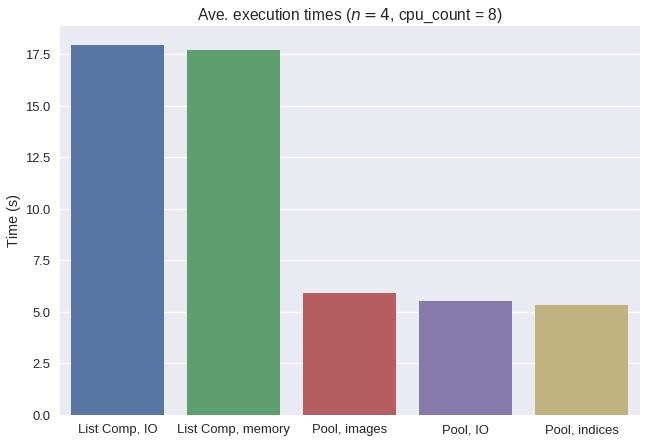

In [152]:
import pandas as pd
import seaborn as sns

sns.set('talk')

results = [meth1_times, meth2_times, meth3_times, meth4_times, meth5_times]
times = np.asarray([x.average for x in results])
stdevs = np.asarray([x.stdev for x in results])
methods = ['List Comp, IO', 'Pool, IO', 'List Comp, memory', 'Pool, images', 'Pool, indices']

df_results = pd.DataFrame({
    'method': methods,
    'time': times,
    'stdev': stdevs
})

sns.barplot(x='method', y='time', data=df_results.sort_values(by='time', ascending=False))
plt.xlabel('')
plt.ylabel('Time (s)')
plt.title('Ave. execution times ($n=4$, cpu_count = 8)')
plt.show()

## Bonus: Using progress bars to work with multiprocessing.Pool

In [112]:
def _process_image(path):
    return detect_nuclei(io.imread(path))

def process_images_progress(paths):
    with mp.Pool() as pool:
        return list(tqdm(pool.imap(_process_image, paths), total=len(paths)))

centers = process_images_progress(paths)

  0%|          | 0/240 [00:00<?, ?it/s]

In [141]:
mp.cpu_count()

8